<a href="https://colab.research.google.com/github/ustcsteve/XGBoost-Use-Guide/blob/main/XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Step1: Install XGBoost

In [31]:
%pip install xgboost

In [32]:
# check xgboost version
import xgboost as xgb
print(xgb.__version__)

0.90


Current version is 0.90. 

Step2. Import dataset

Data Set Information:
Biomedical data set built by Dr. Henrique da Mota during a medical residence period in the Group of Applied Research in Orthopaedics (GARO) of the Centre MÃ©dico-Chirurgical de RÃ©adaptation des Massues, Lyon, France. The data have been organized in two different but related classification tasks. The first task consists in classifying patients as belonging to one out of three categories: Normal (100 patients), Disk Hernia (60 patients) or Spondylolisthesis (150 patients). For the second task, the categories Disk Hernia and Spondylolisthesis were merged into a single category labelled as 'abnormal'. Thus, the second task consists in classifying patients as belonging to one out of two categories: Normal (100 patients) or Abnormal (210 patients). We provide files also for use within the WEKA environment.

Attribute Information:
Each patient is represented in the data set by six biomechanical attributes derived from the shape and orientation of the pelvis and lumbar spine (in this order): pelvic incidence, pelvic tilt, lumbar lordosis angle, sacral slope, pelvic radius and grade of spondylolisthesis. The following convention is used for the class labels: DH (Disk Hernia), Spondylolisthesis (SL), Normal (NO) and Abnormal (AB).

http://archive.ics.uci.edu/ml/datasets/vertebral+column

Import pandas to read csv into dataframe; import numpy for mathmatical operations of arrays

In [33]:
import pandas as pd
import numpy as np

Read csv file into dataframe

In [34]:
df = pd.read_csv('bankmarketing_train.csv', na_values=('unknown', 'NA', 'NaN', 'None', '', ' '))

In [35]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,57,technician,married,high.school,no,no,yes,cellular,may,mon,371,1,999,1,failure,-1.8,92.893,-46.2,1.299,5099.1,no
1,55,NaN,married,NaN,NaN,yes,no,telephone,may,thu,285,2,999,0,nonexistent,1.1,93.994,-36.4,4.860,5191.0,no
2,33,blue-collar,married,basic.9y,no,no,no,cellular,may,fri,52,1,999,1,failure,-1.8,92.893,-46.2,1.313,5099.1,no
3,36,admin.,married,high.school,no,no,no,telephone,jun,fri,355,4,999,0,nonexistent,1.4,94.465,-41.8,4.967,5228.1,no
4,27,housemaid,married,high.school,no,yes,no,cellular,jul,fri,189,2,999,0,nonexistent,1.4,93.918,-42.7,4.963,5228.1,no


In [60]:
df.isnull().mean()

age               0.000000
job               0.008346
marital           0.002003
education         0.042367
default           0.208892
housing           0.023733
loan              0.023733
contact           0.000000
month             0.000000
day_of_week       0.000000
duration          0.000000
campaign          0.000000
pdays             0.000000
previous          0.000000
poutcome          0.000000
emp.var.rate      0.000000
cons.price.idx    0.000000
cons.conf.idx     0.000000
euribor3m         0.000000
nr.employed       0.000000
y                 0.000000
dtype: float64

In [61]:
df.shape

(32950, 21)

In [63]:
df=df.dropna()

In [64]:
df.shape

(24384, 21)

In [36]:
df.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

In [37]:
df['job']=df['job'].astype("category")
df['marital']=df['marital'].astype("category")
df['education']=df['education'].astype("category")
df['default']=df['default'].astype("category")
df['housing']=df['housing'].astype("category")
df['loan']=df['loan'].astype("category")
df['contact']=df['contact'].astype("category")
df['month']=df['month'].astype("category")
df['day_of_week']=df['day_of_week'].astype("category")
df['poutcome']=df['poutcome'].astype("category")
df['y']=df['y'].astype("category")

In [ ]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [42]:
from sklearn.preprocessing import OneHotEncoder

In [43]:
onehot_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'poutcome', 'y']
onehot_df = df[onehot_columns]
onehot_df = pd.get_dummies(onehot_df, columns = onehot_columns)
df_onehot_drop = df.drop(onehot_columns, axis = 1)
df_onehot_final = pd.concat([df_onehot_drop, onehot_df], axis = 1)

In [44]:
df_onehot_final.head()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,default_no,default_yes,housing_no,housing_yes,loan_no,loan_yes,contact_cellular,contact_telephone,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success,y_no,y_yes
0,57,371,1,999,1,-1.8,92.893,-46.2,1.299,5099.1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0
1,55,285,2,999,0,1.1,93.994,-36.4,4.860,5191.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0
2,33,52,1,999,1,-1.8,92.893,-46.2,1.313,5099.1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0
3,36,355,4,999,0,1.4,94.465,-41.8,4.967,5228.1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0
4,27,189,2,999,0,1.4,93.918,-42.7,4.963,5228.1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0


In [45]:
df_onehot_final.dtypes

age                                int64
duration                           int64
campaign                           int64
pdays                              int64
previous                           int64
emp.var.rate                     float64
cons.price.idx                   float64
cons.conf.idx                    float64
euribor3m                        float64
nr.employed                      float64
job_admin.                         uint8
job_blue-collar                    uint8
job_entrepreneur                   uint8
job_housemaid                      uint8
job_management                     uint8
job_retired                        uint8
job_self-employed                  uint8
job_services                       uint8
job_student                        uint8
job_technician                     uint8
job_unemployed                     uint8
marital_divorced                   uint8
marital_married                    uint8
marital_single                     uint8
education_basic.

In [50]:
#df_onehot_final.isnull().sum()

There are quite a lot of null values.

In [49]:
#df_onehot_final.isnull().mean()

There are about maximum 20.9% missing values in the default column. Since XGBoost can handle missing values like other tree based algorithms, we keep the missing values without imputing them.

In [51]:
df_onehot_final.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,default_no,default_yes,housing_no,housing_yes,loan_no,loan_yes,contact_cellular,contact_telephone,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success,y_no,y_yes
count,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000
mean,40.040212,257.335205,2.561730,962.174780,0.174780,0.076228,93.574243,-40.518680,3.615654,5166.859608,0.253080,0.223247,0.036206,0.025918,0.071108,0.042124,0.034598,0.095933,0.020698,0.164674,0.024067,0.111563,0.605948,0.280486,0.101153,0.056055,0.147496,0.229226,0.000455,0.128346,0.294901,0.791017,0.000091,0.453293,0.522974,0.824461,0.151806,0.635690,0.364310,0.063976,0.148164,0.004370,0.174598,0.129014,0.012777,0.336055,0.100030,0.017269,0.013748,0.189954,0.206434,0.210531,0.196783,0.196297,0.104734,0.861730,0.033536,0.887951,0.112049
std,10.432313,257.331700,2.763646,187.646785,0.496503,1.572242,0.578636,4.623004,1.735748,72.208448,0.434783,0.416429,0.186806,0.158893,0.257009,0.200876,0.182762,0.294504,0.142374,0.370891,0.153259,0.314833,0.488653,0.449243,0.301536,0.230031,0.354605,0.420341,0.021332,0.334480,0.456005,0.406589,0.009542,0.497821,0.499479,0.380433,0.358838,0.481243,0.481243,0.244713,0.355268,0.065964,0.379629,0.335220,0.112312,0.472365,0.300045,0.130272,0.116445,0.392271,0.404752,0.407692,0.397573,0.397202,0.306216,0.345188,0.180033,0.315431,0.315431
min,17.000000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32.000000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
50%,38.000000,179.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000

Exploratory Data Analysis by Pandas_Profiling

In [ ]:
%pip install pandas-profiling --upgrade

     |████████████████████████████████| 261 kB 4.5 MB/s 
     |████████████████████████████████| 303 kB 64.1 MB/s 
     |████████████████████████████████| 10.9 MB 46.5 MB/s 
     |████████████████████████████████| 63 kB 1.5 MB/s 
     |████████████████████████████████| 596 kB 62.3 MB/s 
     |████████████████████████████████| 102 kB 11.2 MB/s 
     |████████████████████████████████| 3.1 MB 49.9 MB/s 
     |████████████████████████████████| 675 kB 52.5 MB/s 
     |████████████████████████████████| 812 kB 66.0 MB/s 
     |████████████████████████████████| 38.1 MB 1.1 MB/s 
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27098 sha256=f04cdca6fa60c146f739c08ea1a636584424cded692321fd6b41bd0ac43dc178
  Stored in directory: /root/.cache/pip/wheels/70/e1/52/5b14d250ba868768823940c3229e9950d201a26d0bd3ee8655
  Created wheel for imagehash: filename=ImageHash-4.2.1-py2.py3-none-any.whl size=295207 sha256=809cc2170f63739706275da354da83c3ddb151c9e4039a64180c388fb9d11ccb
 

In [ ]:
from pandas_profiling import ProfileReport
prof = ProfileReport(df)
prof.to_file(output_file='output.html')

ImportError: ignored

Get the data dimensions

In [52]:
df_onehot_final.shape

(32950, 59)

Get the names of all columns 

In [53]:
df_onehot_final.columns

Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed',
       'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'marital_divorced',
       'marital_married', 'marital_single', 'education_basic.4y',
       'education_basic.6y', 'education_basic.9y', 'education_high.school',
       'education_illiterate', 'education_professional.course',
       'education_university.degree', 'default_no', 'default_yes',
       'housing_no', 'housing_yes', 'loan_no', 'loan_yes', 'contact_cellular',
       'contact_telephone', 'month_apr', 'month_aug', 'month_dec', 'month_jul',
       'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct',
       'month_sep', 'day_of_week_fri', 'day_of_week_mon', 'day_of_week_thu',
       'day_of_week_tue', 'day_of_week_wed

Step 3. Isolate features from the label for classification

This example is going to use cross validation to show how to use XGBoost in classification analysis using accuracy as the metric.

In [56]:
X, y = df_onehot_final.iloc[:,:-2],df_onehot_final.iloc[:,-2]

In [57]:
X.columns

Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed',
       'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'marital_divorced',
       'marital_married', 'marital_single', 'education_basic.4y',
       'education_basic.6y', 'education_basic.9y', 'education_high.school',
       'education_illiterate', 'education_professional.course',
       'education_university.degree', 'default_no', 'default_yes',
       'housing_no', 'housing_yes', 'loan_no', 'loan_yes', 'contact_cellular',
       'contact_telephone', 'month_apr', 'month_aug', 'month_dec', 'month_jul',
       'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct',
       'month_sep', 'day_of_week_fri', 'day_of_week_mon', 'day_of_week_thu',
       'day_of_week_tue', 'day_of_week_wed

In [ ]:
df_dmatrix = xgb.DMatrix(data=X,label=y)

In [ ]:
xgb.cv({'max_depth': 3, 'eta': 1, 'objective': 'binary:logitraw'},
       df_dmatrix, stratified=y, nfold=5, metrics=["auc", "logloss", "error"])

,train-auc-mean,train-auc-std,train-error-mean,train-error-std,train-logloss-mean,train-logloss-std,test-auc-mean,test-auc-std,test-error-mean,test-error-std,test-logloss-mean,test-logloss-std
0,0.897831,0.005574,0.098111,0.000570,1.974004,0.008219,0.894673,0.010773,0.098574,0.001957,1.988150,0.083187
1,0.931471,0.004715,0.090303,0.001445,2.150992,0.274399,0.928485,0.005938,0.091745,0.004571,2.187016,0.229216
2,0.939281,0.000648,0.089977,0.001272,2.325771,0.096130,0.937362,0.003486,0.090925,0.002817,2.330803,0.151400
3,0.941469,0.001198,0.088460,0.000770,2.218131,0.148051,0.939004,0.002680,0.091199,0.003526,2.253024,0.202574
4,0.943734,0.001046,0.088300,0.000750,2.207029,0.140574,0.941512,0.003306,0.090319,0.002732,2.230257,0.174261
5,0.945131,0.000666,0.088065,0.001472,2.189363,0.090416,0.942378,0.003528,0.089833,0.002413,2.210454,0.117562
6,0.946334,0.000736,0.086980,0.001899,2.201240,0.075567,0.942741,0.003377,0.090045,0.002820,2.263351,0.090798
7,0.947545,0.000636,0.086123,0.001248,2.174869,0.094719,0.943306,0.003488,0.089499,0.003163,2.257462,0.118841
8,0.948748,0.000940,0.085190,0.001161,2.152099,0.043639,0.943933,0.002858,0.088498,0.003096,2.263453,0.058627
9,0.949379,0.000729,0.084750,0.001138,2.148807,0.046002,0.944198,0.003008,0.088225,0.003036,2.292196,0.071946


Step 4. Tune XGBoost Hyperparameters

XGBoost is an ensemble of weak tree models. To optimize its performance, its number of trees, tree depth, learning rate, number of samples, number of features may need to adjust.

a. Explore number of trees

In [ ]:
from sklearn.model_selection import GridSearchCV

params = { 'max_depth': [3,6,10],
           'learning_rate': [0.01, 0.05, 0.1],
           'n_estimators': [100, 500, 1000],
           'colsample_bytree': [0.3, 0.7]}
xgbc = xgb.XGBClassifier(seed = 20)
clf = GridSearchCV(estimator=xgbc, 
                   param_grid=params,
                   scoring='neg_log_loss', 
                   verbose=1)
clf.fit(X, y)
print("Best parameters:", clf.best_params_)
print("Lowest log_loss: ", (-clf.best_score_)**(1/2.0))

Fitting 5 folds for each of 54 candidates, totalling 270 fits


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

params = { 'max_depth': [3, 5, 6, 10, 15, 20],
           'learning_rate': [0.01, 0.1, 0.2, 0.3],
           'subsample': np.arange(0.5, 1.0, 0.1),
           'colsample_bytree': np.arange(0.4, 1.0, 0.1),
           'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
           'n_estimators': [100, 500, 1000]}
xgbc = xgb.XGBClassifier(seed = 20)
clf = GridSearchCV(estimator=xgbc, 
                         param_distributions=params,
                         scoring='neg_log_loss',
                         n_iter=25,
                         verbose=1)
clf.fit(X, y)
print("Best parameters:", clf.best_params_)
print("Lowest log_loss: ", (-clf.best_score_)**(1/2.0))

In [ ]:
xgb.cv({'max_depth': 3, 'eta': 1, 'objective': 'binary:logitraw'},
       df_dmatrix, stratified=y, nfold=5, metrics=["auc", "logloss", "error"])
# explore xgboost number of trees effect on performance

from matplotlib import pyplot
 
# get a list of models to evaluate
def get_models():
	models = dict()
	trees = [10, 50, 100, 500, 1000, 5000]
	for n in trees:
		models[str(n)] = XGBClassifier(n_estimators=n)
	return models
 
# evaluate a give model using cross-validation
def evaluate_model(model):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores
  
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

>10 0.833 (0.072)
>50 0.832 (0.078)
>100 0.830 (0.070)
>500 0.829 (0.076)
>1000 0.828 (0.078)
>5000 0.824 (0.075)


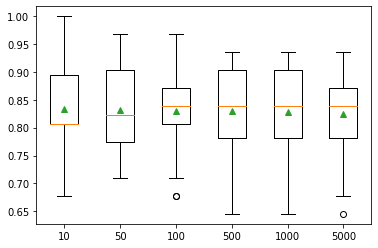

In [ ]:

# explore xgboost number of trees effect on performance

from matplotlib import pyplot
 
# get a list of models to evaluate
def get_models():
	models = dict()
	trees = [10, 50, 100, 500, 1000, 5000]
	for n in trees:
		models[str(n)] = XGBClassifier(n_estimators=n)
	return models
 
# evaluate a give model using cross-validation
def evaluate_model(model):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores
  
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

The best number of trees is 10 that gives an accuracy of 0.833.

b. Explore Tree Depth

>1 0.780 (0.067)
>2 0.802 (0.062)
>3 0.833 (0.072)
>4 0.838 (0.064)
>5 0.845 (0.060)
>6 0.837 (0.062)
>7 0.840 (0.064)
>8 0.838 (0.065)
>9 0.839 (0.061)
>10 0.839 (0.061)


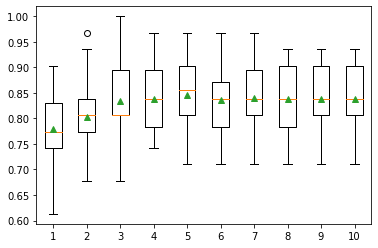

In [ ]:

# explore xgboost number of trees effect on performance

from matplotlib import pyplot
 
# get a list of models to evaluate
def get_models():
	models = dict()
	for i in range(1,11):
		models[str(i)] = XGBClassifier(n_estimators=10, max_depth=i)
	return models
 
# evaluate a give model using cross-validation
def evaluate_model(model):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores
  
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

The best tree depth wiht 10 trees is 5 that gives an accuracy of 0.845.

c. Explore Learning Rate

>0.0001 0.845 (0.060)
>0.0010 0.845 (0.060)
>0.0100 0.845 (0.060)
>0.1000 0.845 (0.060)
>1.0000 0.845 (0.060)


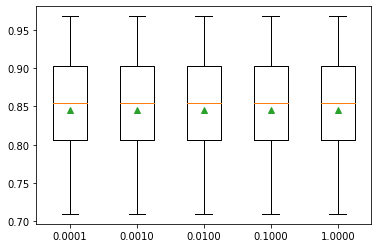

In [ ]:
# get a list of models to evaluate
def get_models():
	models = dict()
	rates = [0.0001, 0.001, 0.01, 0.1, 1.0]
	for r in rates:
		key = '%.4f' % r
		models[key] = XGBClassifier(n_estimators=10, max_depth=5, eta=r)
	return models
 
# evaluate a give model using cross-validation
def evaluate_model(model):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores
  
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

The model doesn't vary by its learning rate.

d. Explore Number of Samples

>0.1 0.801 (0.061)
>0.2 0.818 (0.061)
>0.3 0.835 (0.054)
>0.4 0.841 (0.059)
>0.5 0.846 (0.058)
>0.6 0.839 (0.071)
>0.7 0.839 (0.065)
>0.8 0.839 (0.070)
>0.9 0.835 (0.067)
>1.0 0.845 (0.060)


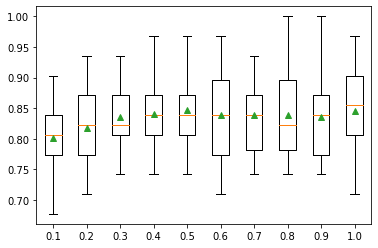

In [ ]:
import numpy as np
# get a list of models to evaluate
def get_models():
	models = dict()
	for i in np.arange(0.1, 1.1, 0.1):
		key = '%.1f' % i
		models[key] = XGBClassifier(n_estimators=10, max_depth=5, subsample=i)
	return models
 
# evaluate a give model using cross-validation
def evaluate_model(model):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores
  
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

When XGBoost randomly samples half of the training set, it gives the best accuracy of 0.846.

e. Explore Number of Features

>0.1 0.703 (0.052)
>0.2 0.703 (0.052)
>0.3 0.703 (0.052)
>0.4 0.765 (0.073)
>0.5 0.818 (0.054)
>0.6 0.818 (0.054)
>0.7 0.815 (0.056)
>0.8 0.815 (0.056)
>0.9 0.837 (0.056)
>1.0 0.846 (0.058)


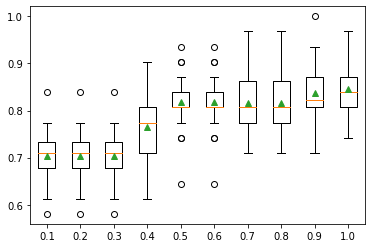

In [ ]:
import numpy as np
# get a list of models to evaluate
def get_models():
	models = dict()
	for i in np.arange(0.1, 1.1, 0.1):
		key = '%.1f' % i
		models[key] = XGBClassifier(n_estimators=10, max_depth=5, subsample=0.5, colsample_bytree=i)
	return models
 
# evaluate a give model using cross-validation
def evaluate_model(model):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores
  
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

The model performs best when all 6 features are used along with 10 trees, 5 tree depth, randomly used 50% data for training with minimal impact from its learning rate. 